### SECTION B
### Natural Language Processing (NLP) Project: Sentiment Analysos on the Finance Domain

***

#### Data Sourcing

Dataset Characteristics:

Source: Reddit finance-related subreddits (stocks, investing, wallstreetbets, pennystocks, FinancialPlanning)

Content: 200 submissions with titles, text content, metadata, and keyword hits

Temporal Range: August-October 2025

Key Features: Submission metrics (score, comments, upvote ratio), financial topics, sentiment indicators

Domain Relevance: The data captures real-time investor sentiment, market reactions to political/economic events, and retail investor behavior patterns.

***


Primary Research Questions:

1. Sentiment & Market Impact: How does sentiment in financial subreddits correlate with market-moving events and political announcements?

2. Topic Evolution: What are the dominant financial topics discussed across different subreddits and how do they evolve over time?

3. Community Behavior: How do discussion patterns and sentiment differ between sophisticated investing communities (investing) and speculative communities (wallstreetbets)?

4. Event Reaction Analysis: How do Reddit finance communities react to major economic events (tariffs, Fed decisions, earnings reports)?

5. Predictive Potential: Can sentiment analysis of Reddit finance posts provide early indicators of market volatility or sector-specific movements?

***

### Data Preprocessing and EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# Load and preprocess data
df = pd.read_csv('reddit_finance_submissions.csv')

# Basic data info
print("Dataset Shape:", df.shape)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nSubreddit Distribution:")
print(df['subreddit'].value_counts())

Dataset Shape: (154, 15)

Missing Values:
type               0
submission_id      0
comment_id       154
author             2
created_utc        0
subreddit          0
score              0
num_comments       0
upvote_ratio       0
title              0
selftext          31
comment_body     154
permalink          0
url                0
keyword_hits      99
dtype: int64

Subreddit Distribution:
subreddit
pennystocks          49
wallstreetbets       37
investing            32
FinancialPlanning    20
stocks               16
Name: count, dtype: int64


In [4]:
# Data cleaning function
def clean_text(text):
    if pd.isna(text):
        return ""
    # Remove URLs, special characters, and numbers
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

# Apply cleaning
df['clean_title'] = df['title'].apply(clean_text)
df['clean_selftext'] = df['selftext'].apply(clean_text)

In [5]:
# Combine title and text for analysis
df['combined_text'] = df['clean_title'] + " " + df['clean_selftext']

In [6]:
# Extract date features
df['created_utc'] = pd.to_datetime(df['created_utc'])
df['date'] = df['created_utc'].dt.date
df['day_of_week'] = df['created_utc'].dt.day_name()
df['hour'] = df['created_utc'].dt.hour

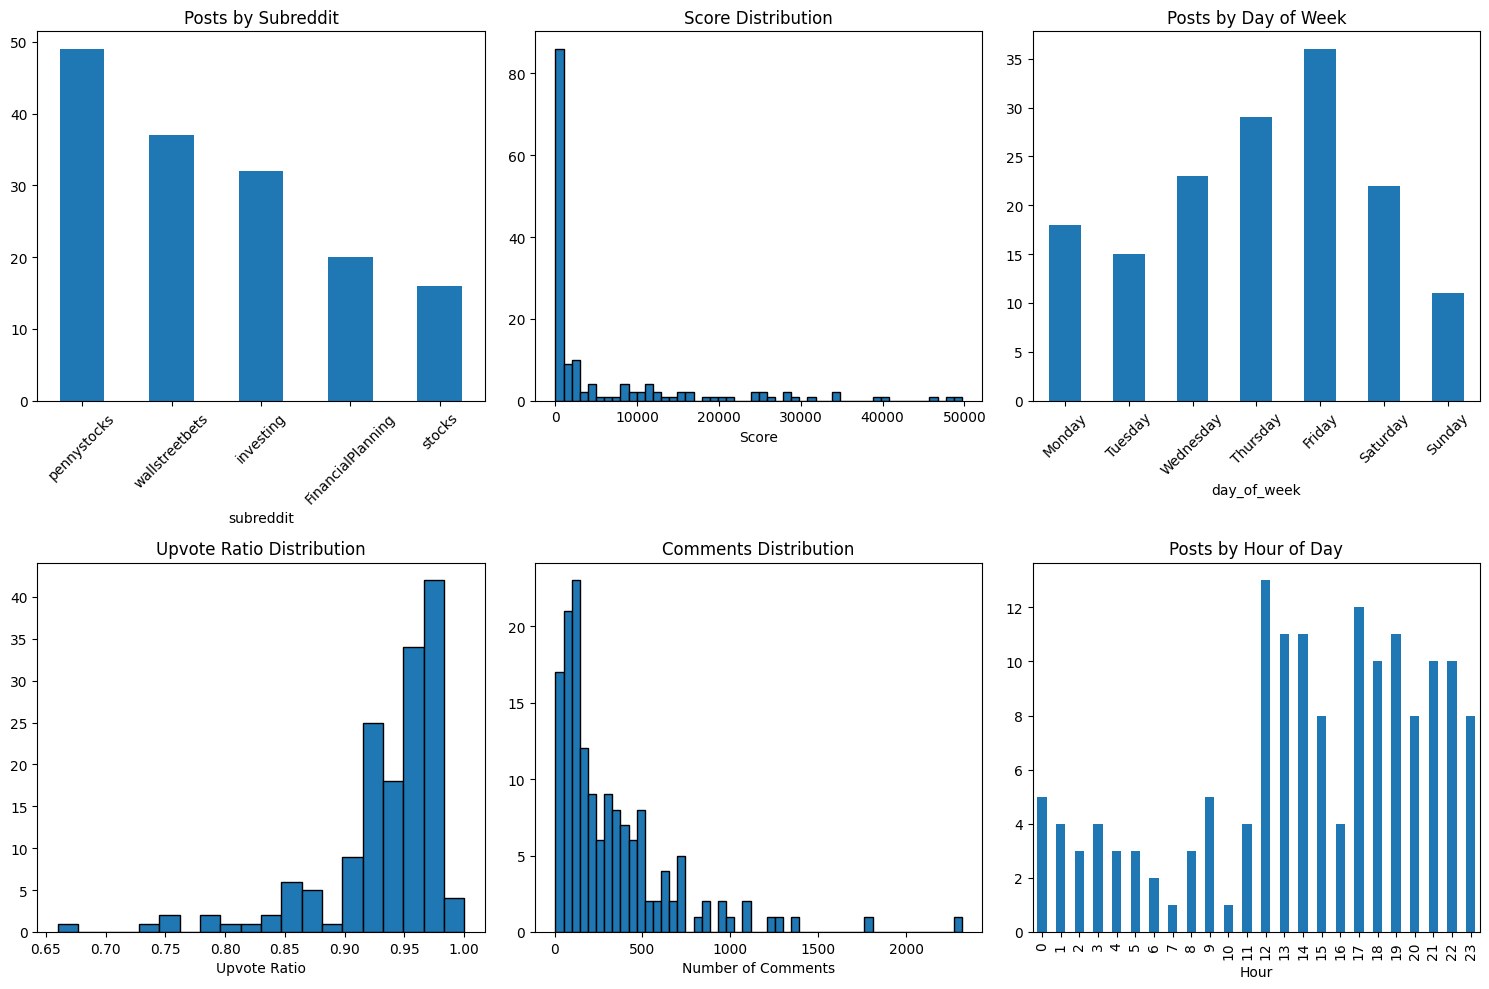

In [7]:
# EDA Visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Submission volume by subreddit
plt.subplot(2, 3, 1)
df['subreddit'].value_counts().plot(kind='bar')
plt.title('Posts by Subreddit')
plt.xticks(rotation=45)

# Plot 2: Score distribution
plt.subplot(2, 3, 2)
plt.hist(df['score'], bins=50, edgecolor='black')
plt.title('Score Distribution')
plt.xlabel('Score')

# Plot 3: Posts by day of week
plt.subplot(2, 3, 3)
df['day_of_week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(kind='bar')
plt.title('Posts by Day of Week')
plt.xticks(rotation=45)

# Plot 4: Upvote ratio distribution
plt.subplot(2, 3, 4)
plt.hist(df['upvote_ratio'], bins=20, edgecolor='black')
plt.title('Upvote Ratio Distribution')
plt.xlabel('Upvote Ratio')

# Plot 5: Comments distribution
plt.subplot(2, 3, 5)
plt.hist(df['num_comments'], bins=50, edgecolor='black')
plt.title('Comments Distribution')
plt.xlabel('Number of Comments')

# Plot 6: Hourly distribution
plt.subplot(2, 3, 6)
df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Posts by Hour of Day')
plt.xlabel('Hour')

plt.tight_layout()
plt.show()

In [8]:
# Keyword analysis
all_keywords = ' '.join(df['keyword_hits'].dropna()).split(';')
keyword_counts = Counter([kw.strip() for kw in all_keywords if kw.strip()])
print("\nTop Keywords:")
for keyword, count in keyword_counts.most_common(10):
    print(f"{keyword}: {count}")


Top Keywords:
fed: 5
cut: 2
credit: 2
treasury: 2
volatility cut: 2
inflation: 2
loan: 2
earnings inflation bank: 1
fed volatility fed earnings: 1
guidance earnings: 1


In [9]:
# Temporal analysis of key events
trump_tariff_posts = df[df['combined_text'].str.contains('tariff|trump', case=False, na=False)]
print(f"\nPosts about Trump/tariffs: {len(trump_tariff_posts)}")


Posts about Trump/tariffs: 30


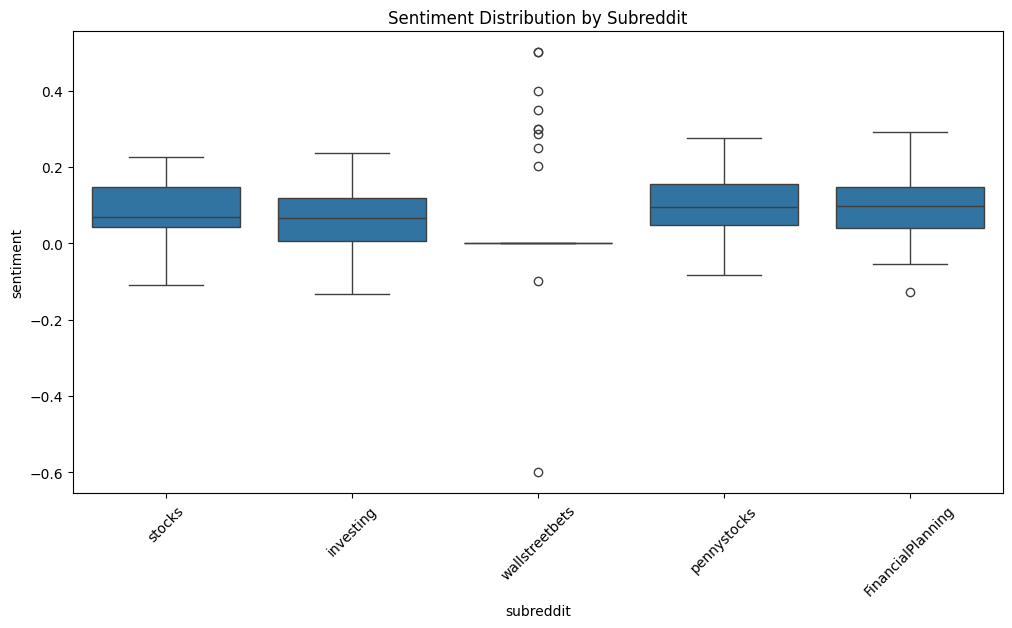

In [10]:
# Sentiment distribution by subreddit
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['sentiment'] = df['combined_text'].apply(get_sentiment)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='subreddit', y='sentiment')
plt.title('Sentiment Distribution by Subreddit')
plt.xticks(rotation=45)
plt.show()

***

### Sentiment Classification

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [12]:
# Create sentiment labels based on polarity scores
def sentiment_label(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['sentiment'].apply(sentiment_label)

print("Sentiment Distribution:")
print(df['sentiment_label'].value_counts())

Sentiment Distribution:
sentiment_label
neutral     94
positive    56
negative     4
Name: count, dtype: int64


In [13]:
# Prepare features and labels
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(df['combined_text'])
y = df['sentiment_label']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [14]:
# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Train SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [16]:
# Make predictions
rf_pred = rf_classifier.predict(X_test)
svm_pred = svm_classifier.predict(X_test)

***

### Model Evaluation


Random Forest Performance:
Accuracy: 0.6382978723404256

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         1
     neutral       0.64      0.97      0.77        29
    positive       0.67      0.12      0.20        17

    accuracy                           0.64        47
   macro avg       0.43      0.36      0.32        47
weighted avg       0.63      0.64      0.55        47



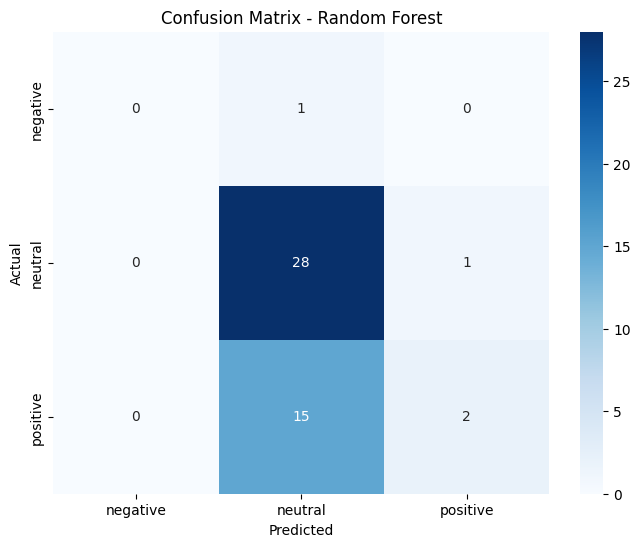


SVM Performance:
Accuracy: 0.574468085106383

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         1
     neutral       0.60      0.90      0.72        29
    positive       0.25      0.06      0.10        17

    accuracy                           0.57        47
   macro avg       0.28      0.32      0.27        47
weighted avg       0.46      0.57      0.48        47



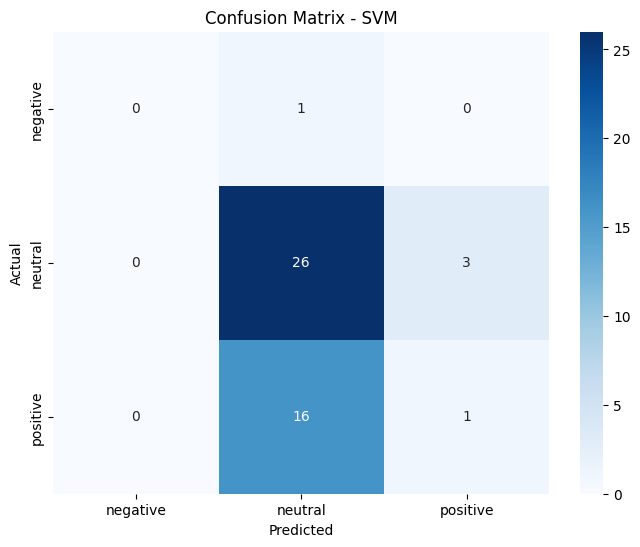

In [17]:
import warnings
warnings.filterwarnings("ignore")


# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Evaluate both models
evaluate_model(y_test, rf_pred, "Random Forest")
evaluate_model(y_test, svm_pred, "SVM")

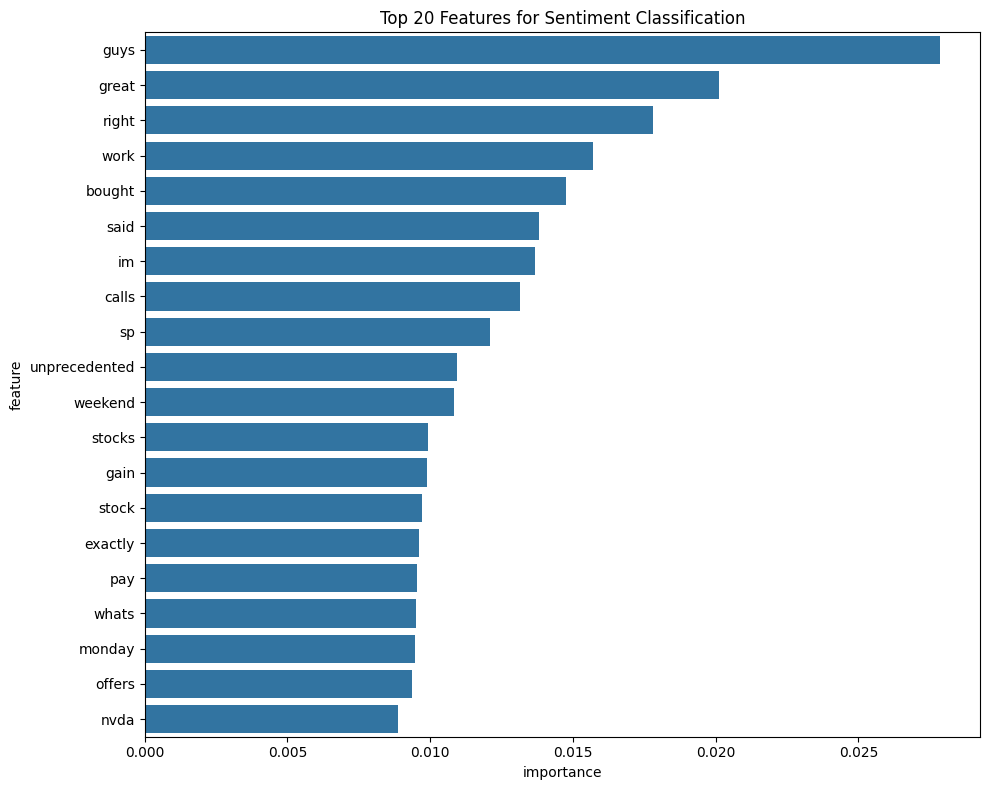

In [18]:
# Feature importance analysis (for Random Forest)
feature_names = vectorizer.get_feature_names_out()
importances = rf_classifier.feature_importances_
feature_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
top_features = feature_imp_df.nlargest(20, 'importance')

plt.figure(figsize=(10, 8))
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Top 20 Features for Sentiment Classification')
plt.tight_layout()
plt.show()

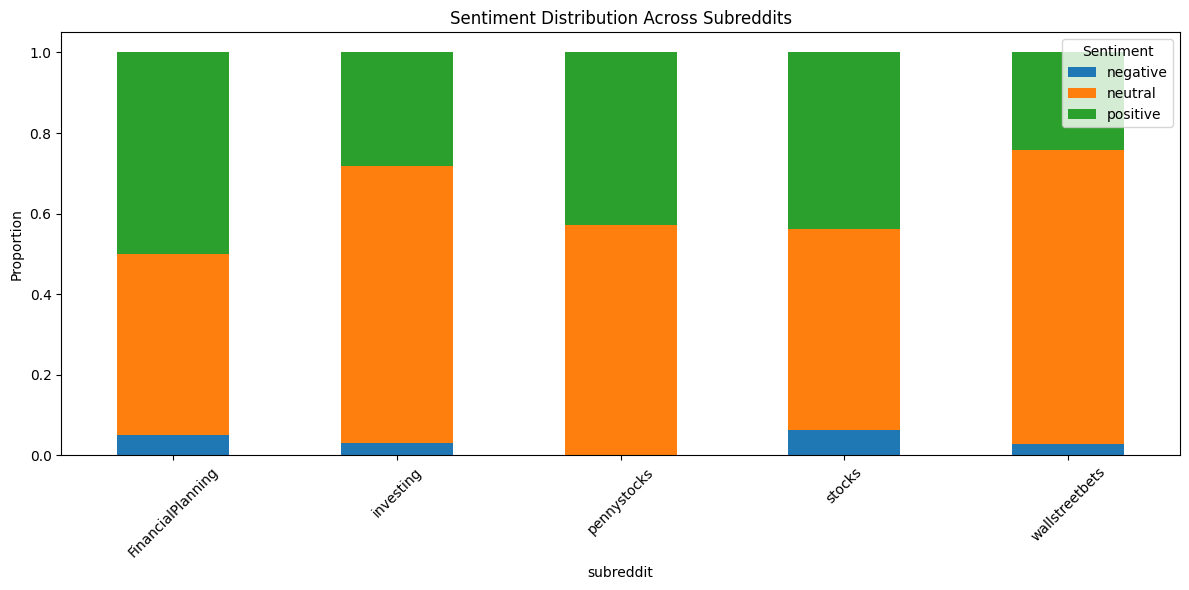

In [19]:
# Cross-subreddit sentiment analysis
subreddit_sentiment = df.groupby('subreddit')['sentiment_label'].value_counts(normalize=True).unstack()
subreddit_sentiment.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Distribution Across Subreddits')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

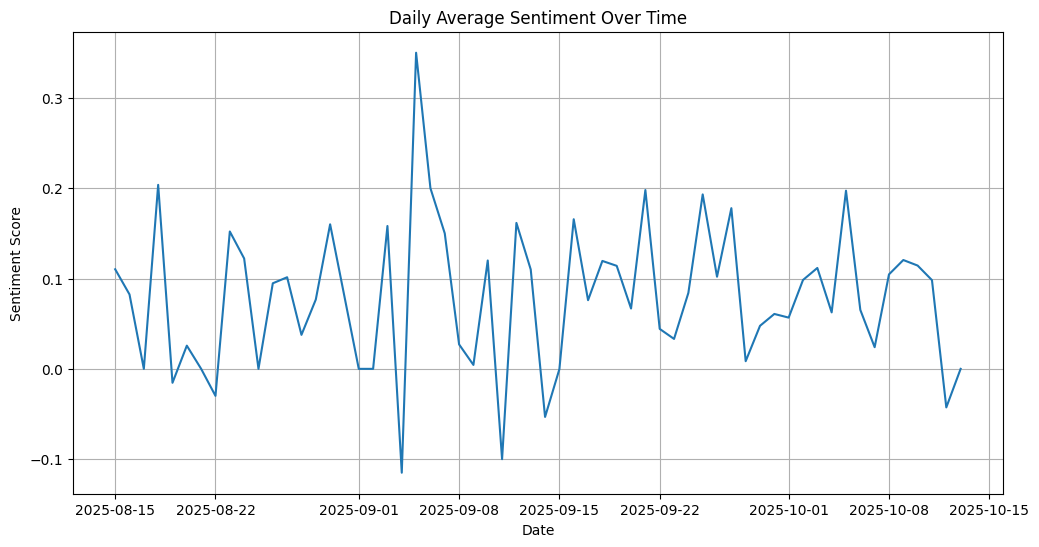

In [20]:
# Temporal sentiment trends
daily_sentiment = df.groupby('date')['sentiment'].mean()
plt.figure(figsize=(12, 6))
daily_sentiment.plot()
plt.title('Daily Average Sentiment Over Time')
plt.ylabel('Sentiment Score')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [21]:
# Key event sentiment analysis
major_events = {
    'Trump Tariffs': '2025-10-10',
    'Fed Rate Decision': '2025-09-17',
    'Jobs Report Revision': '2025-09-09'
}

for event, date in major_events.items():
    event_date = pd.to_datetime(date)
    event_posts = df[df['date'] == event_date.date()]
    if len(event_posts) > 0:
        avg_sentiment = event_posts['sentiment'].mean()
        print(f"{event} ({date}): Average Sentiment = {avg_sentiment:.3f}")

Trump Tariffs (2025-10-10): Average Sentiment = 0.114
Fed Rate Decision (2025-09-17): Average Sentiment = 0.076
Jobs Report Revision (2025-09-09): Average Sentiment = 0.004
